In [2]:
import json
import os
import subprocess

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy

# Particles

In [161]:
class ParticleAnalysis():

    def __init__(self, n_sigma, length, xdim, ydim, sigma, line_idx= None, beam = 2, plane = 'V'):

        self.beam = beam
        self.plane = plane
        self.n_sigma = n_sigma
        self.length = length
        self.xdim = xdim
        self.ydim = ydim
        self.sigma = sigma
        self.jaw_L = sigma * n_sigma
        self.line_idx = line_idx
        self.p0c = None
        self.npart = None
        self.data = None
        self.abs_y_low = self.jaw_L
        self.abs_y_up = self.jaw_L + self.ydim
        self.abs_x_low = -self.xdim/2
        self.abs_x_up = self.xdim/2

        self.n_jobs = None
        self.part_per_job = None
        
        self.lossmap = None 
        self.losses = None

        self.coll_names = {'TCCS': 'tccs.5r3.b2', 'TCCP': 'tccp.4l3.b2', 'TARGET': 'target.4l3.b2', 'TCLA': 'tcla.a5l3.b2'}
            
            
    def retreive_file_path(self, prefix_name, file_name = 'particle*.h5', path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"):

        test_list = [path + i for i in os.listdir(path) if prefix_name in i]
        for test_name in test_list:

            n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

            path_list =[]

            for i in range(n_jobs):
                file_path_part = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/' + file_name, shell=True)).decode('ascii').strip()
                if os.path.exists(file_path_part):
                    path_list.append(file_path_part)

            n_jobs_verify  = len(path_list)
            if n_jobs != n_jobs_verify:
                print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)
        return path_list   
    
    

    def load_particles(self, path, df_key, Condor=True, 
                       file_name='particle*.h5', 
                       default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                       part_per_job = 100000):
                
        if Condor == True:
            self.part_per_job = part_per_job
            h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name)
            self.n_jobs = len(h5_file_path)
        else:
            h5_file_path = (subprocess.check_output("echo " + default_path + path +file_name, shell=True)).decode('ascii').strip()

        if not hasattr(h5_file_path, '__iter__') or isinstance(h5_file_path, str):
            h5_file_path = [h5_file_path]

        df_particles = pd.DataFrame()
        npart = 0
        i = 0 
        for file in h5_file_path:
            try:
                df_tmp = pd.read_hdf(file, key=df_key) #test_particles_B2V
                df_tmp['particle_id'] = df_tmp['particle_id'] + part_per_job*i    
                df_tmp['parent_particle_id'] = df_tmp['parent_particle_id'] + part_per_job*i
                df_particles = pd.concat([df_particles, df_tmp])
            except FileNotFoundError:
                print(f"Error: File not found at {file}")
                continue
            except pd.errors.EmptyDataError:
                print(f"Error: The HDF5 file at {file} is empty.")
                continue
            except Exception as e:
                print(f"Error: An unexpected error occurred - {e}")
                continue
            npart = npart + len(df_tmp)
            i = i + 1
                       
        self.npart = npart       
        self.data = df_particles
            
        p0c = None
        if len(self.data['p0c'].unique()) == 1:
            p0c = self.data['p0c'].unique()[0]
        else:
            print('There are particles at different energies')            
        self.p0c = p0c
    


    def plot_rectangle(self, ax, x_low, x_up, y_low, y_up):
        rect = patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


    def plot_xy_distribution(self, fig, ax, x, y):

        h = ax.hist2d(x, y, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax.set_xlabel(r'x [mm]')
        ax.set_ylabel(r'y [mm]')
        ax.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        ax.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        ax_tw = ax.twinx()
        sigma_abs = self.jaw_L/self.n_sigma
        ax_tw.set_ylim(ax.get_ylim()[0]/sigma_abs, ax.get_ylim()[1]/sigma_abs)
        
        if ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 20:
            n_ticks = 2
        elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 20 and ax_tw.get_ylim()[0] - ax_tw.get_ylim()[1] < 60:
            n_ticks = 4
        elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 60 and ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 100:
            n_ticks = 8
        elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 100:
            n_ticks = 16
        yticks = np.arange(np.ceil(ax_tw.get_ylim()[0]), np.floor(ax_tw.get_ylim()[1]) + 1, n_ticks)
        ax_tw.set_yticks(yticks)
        ax_tw.set_ylabel(r' n $\sigma$')
        
        ax_tw.axhline(self.n_sigma, color = 'r', linestyle = '--')
        axins = inset_axes(ax, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax.grid(linestyle=':')



    def plot_py_distribution(self, fig, ax, py, **kwargs):

        ax.hist(py, bins=100) 
        ax.set_xlabel(r'py [$\mu$rad]')
        ax.set_ylabel('')
        ax.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])
        if "log" in kwargs and kwargs['log'] == True: 
            ax.set_yscale("log")


    def plot_distributions(self, x, y, px, py, **kwargs):
        
        hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

        fig1 = plt.figure(figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(x, bins=100)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        ax1.axvline(self.abs_x_low, color = 'r', linestyle = '--')
        ax1.axvline(self.abs_x_up, color = 'r', linestyle = '--')
        ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])

        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(y, bins=100) 
        ax2.set_xlabel('y [mm]')
        ax2.axvline(self.abs_y_low, color = 'r', linestyle = '--')
        ax2.axvline(self.abs_y_up, color = 'r', linestyle = '--')
        ax2.set_ylabel('')
        
        ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        ax2.set_title(f'Total particles: {len(x)},      Hitting particles: {hitting_particles}')

        ax3 = fig1.add_subplot(2,3,3)
        self.plot_xy_distribution(fig1, ax3, x, y)
        self.plot_rectangle(ax3, self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
        

        ax12 = fig1.add_subplot(2,3,4)
        ax12.hist(px, bins=100)
        ax12.set_xlabel(r'px [$\mu$rad]')
        ax12.set_ylabel("")        
        ax12.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])


        ax22 = fig1.add_subplot(2,3,5)
        self.plot_py_distribution(fig1, ax22, py, **kwargs)


        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(px, py, bins=100, norm=matplotlib.colors.LogNorm())  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])
        ax32.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.yticks()[0]])
        axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        if "log" in kwargs and kwargs['log'] == True:  
            ax22.set_yscale("log")
            ax2.set_yscale("log")
            ax12.set_yscale("log")
            ax1.set_yscale("log")

        plt.show()
        
        
    def compute_impact_particles(self, sigma = False, log=False, xpcrit= False, **kwargs):
        if self.data is None:
            self.load_particles(kwargs['h5_file_path'])
        self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], sigma=sigma, log=log, xpcrit=xpcrit)
        
    
    def load_lossmap(self, path, Condor = True, file_name='lossmap*', plot = True, layout = "./input_files/layout_flat_top_b2.tfs", zoom = True, outfile = None):     
        if Condor == True:
            path = self.retreive_file_path(path, file_name=file_name)     
        self.lossmap = lm.SimulatedLossMap(lmtype=lm.LMType[f'B{self.beam}{self.plane}'], machine=lm.Machine.LHC)
        self.lossmap.load_data_json(json_files=path)
        self.losses = self.lossmap._losses
        if plot:    
            lm.plot_lossmap(self.lossmap, zoom = zoom, layout = layout,  outfile = outfile)
            
    def compute_losses(self, path=None):
        if self.lossmap is None:
            self.load_lossmap(path)
        df = self.lossmap._losses
        colls_length_dict = {self.coll_names['TCLA']: 1.0, self.coll_names['TCCS']: 0.004, self.coll_names['TCCP']: 0.07, self.coll_names['TARGET']: 0.005,  'tcp.d6r7.b2': 0.6}
        losses_df = df[df['name'].isin(colls_length_dict.keys())].copy()
        losses_df.loc[:, 'length'] = losses_df['name'].map(colls_length_dict)
        losses_df.loc[:, 'npart']  = losses_df['losses'] * losses_df['length']
        return losses_df
    

    





# ---------------------------------------------------  CRYSTAL   ---------------------------------------------------



class CrystalAnalysis(ParticleAnalysis):

  def __init__(self, n_sigma, length, xdim, ydim, sigma, bend=None, align_angle = None, line_idx= None, 
                beam = 2, plane = 'V',
                pot_crit = 21.34, #16 #eV Silicon
                en_crit = 5.7e9 / 1e-2 #eV/m Silicon    #dp_Si = 1.92e-10 #m
                ):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, line_idx = line_idx, beam = beam, plane = plane, sigma = sigma)
    
    self.align_angle = align_angle
    self.en_crit = en_crit
    self.pot_crit = pot_crit
    self.line_idx = line_idx        
    self.bend = bend 


  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      part_per_job = 100000):
        
    super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job)


    """ai = 0.96e-7
    eUm = 21.34
    xp_crit0 = np.sqrt((2.0e-9*eUm)/self.p0c)
    Rcrit   = (self.p0c/(2.0e-6*eUm))*ai"""

  
    
    xp_crit0 = np.sqrt(2.0*self.pot_crit/self.p0c)
    Rcrit = self.p0c/self.en_crit
    
    #print(f'xp_crit0: {xp_crit0}, Rcrit: {Rcrit}')

    self.xp_crit = xp_crit0*(1-Rcrit/self.bend)
    if(self.xp_crit < 0):
          print("!!!!!!!!!!!!! \nERROR: particles at",self.p0c, f"eV cannot be channeled if bending is {self.bend} m \n!!!!!!!!!!!!!")
    

  def plot_py_distribution(self, fig, ax, py, print=True, **kwargs):
        
        super().plot_py_distribution(fig, ax, py, **kwargs)

        if "xpcrit" in kwargs and kwargs['xpcrit'] == True:   
            new_align_angle = None
            if "align_angle" in kwargs:
                new_align_angle = kwargs['align_angle']
            elif self.align_angle is not None:
                new_align_angle = self.align_angle
             
            if new_align_angle is not None: 
                ax.axvline(new_align_angle, color = 'red', linestyle = '-', alpha = 0.8)
                if(self.xp_crit < 0):
                    print(f"!!!!!!!!!!!!! \nERROR: particles at {self.p0c} cannot be channeled if bending is {self.bend} \n!!!!!!!!!!!!!")
                else:
                    ax.axvline(new_align_angle  + np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    ax.axvline(new_align_angle - np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    chann_mask = (py > new_align_angle  - np.abs(self.xp_crit)) & (py < new_align_angle  + np.abs(self.xp_crit))
                    chann = len(py[chann_mask])
                    if print:
                        ax.set_title(f'N particle inside critical angle range: {chann}')




  def compute_channeled_part_bkp(self, idx):

    df_chann = self.data[(self.data['this_turn']==self.data['at_turn']) & (self.data['at_element']==idx) &  (self.data['py'] > self.align_angle - np.abs(self.xp_crit)) & (self.data['py'] < self.align_angle  + np.abs(self.xp_crit))]
    chann_num = len(df_chann)
    print('Number of channeled particles over hits on crystal: ', chann_num, '/', self.npart)
    if self.n_jobs is not None:
        print(f'over a total number of particles in simulation of {self.n_jobs*self.part_per_job:.2e}')


  def compute_channeled_part(self, impacts):

    channable_ids = self.data[(self.data['py'] > self.align_angle - np.abs(self.xp_crit)) & (self.data['py'] < self.align_angle  + np.abs(self.xp_crit))]['particle_id']
    chann_num = len(np.intersect1d(channable_ids, impacts['particle_id']))
    print('n particles that hit TCCP inside critical angle range: \t', chann_num)
    print('n part inside critical angle range: \t\t\t', len(channable_ids), f'\t\t{chann_num/len(channable_ids)*100:.2f}%' )
    print('n part that hit TCCS (multiple):\t\t\t', self.npart, f'\t{chann_num/self.npart*100:.2f}%')
    print('n part that hit TCCP: \t\t\t\t\t', len(impacts), f'\t\t{chann_num/len(impacts)*100:.2f}%' )
    if self.n_jobs is not None:
        print(f'total n particle in simulation: \t\t\t {self.n_jobs*self.part_per_job:.1e}\t{chann_num/(self.n_jobs*self.part_per_job)*100:.2f}%')


  def optimize_alignment(self):

    data = self.data[['py', 'at_element']]
    min_py = data['py'].min()
    max_py = 0 # data['py'].max()
    
    n_steps = 1000
    x = np.linspace(min_py + self.xp_crit, max_py - self.xp_crit, n_steps)
    y = []
    for i in range(n_steps):
        mask = (data['py'] > x[i] - self.xp_crit) & (data['py'] < x[i] + self.xp_crit)
        y.append(len(data['py'][mask]))

    best_angle = x[y.index(max(y))]

    fig1 = plt.figure(figsize=(15, 5))
    ax1 = fig1.add_subplot(1,2,1)
    ax1.plot(x, y)
    ax1.set_xlabel('angle [rad]')
    ax1.set_ylabel("n_part")
    ax1.axvline(best_angle, color = 'r', linestyle = '-')
    ax1.axvline(self.align_angle, color = 'g', linestyle = '-')

    ax2 = fig1.add_subplot(1,2,2)
    self.plot_py_distribution(fig1, ax2, data['py'], xpcrit=True, align_angle = best_angle, print=False)

    chann_mask = (data['py'] > self.align_angle  - np.abs(self.xp_crit)) & (data['py'] < self.align_angle  + np.abs(self.xp_crit))
    chann = len(data['py'][chann_mask])

    fig1.suptitle(f'Optimal angle {best_angle:.3e},  {max(y)} particles \nAlignment angle {self.align_angle:.3e}, {chann} particles')

    print(f'Delta angle {best_angle - self.align_angle}')



def save_particle_data(self, output_path, key = 'TCCS_impacts'):
        file_name = f'particles_B{self.beam}{self.plane}.h5'
        self.data.to_hdf(output_path + file_name, key = key, mode='w', format='table', complevel=9, complib='blosc')



# ---------------------------------------------------  TARGET   ---------------------------------------------------
    

class TargetAnalysis(ParticleAnalysis):

  def __init__(self, n_sigma, length, xdim, ydim, sigma, line_idx= None, beam = 2, plane = 'V'):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, sigma = sigma, line_idx = line_idx, beam = beam, plane = plane)
    self.impact_part = None
    


  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      part_per_job = 100000):
        
    super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job)

    data = self.data['particle_id']
    duplicated_mask = data.duplicated()
    if len(data[duplicated_mask]) != 0:
        print(f'There are repeated particle ids: {data[duplicated_mask]}')

    
    hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
    self.impact_part = self.data[hit_mask]



  def optimize_POT(self, set = False):
        
        x = self.data['x']
        y = self.data['y']

        abs_x_low = -self.xdim/2
        abs_x_up = self.xdim/2

        nsteps = 100
        steps = np.linspace(self.jaw_L - 3e-3, self.jaw_L + self.ydim, nsteps)
        n_part = []

        for stp in steps:
            abs_y_low = stp
            abs_y_up = stp + self.ydim
            n_part.append(len(x[(x >= abs_x_low) & (x <= abs_x_up) & (y >= abs_y_low) & (y <= abs_y_up)]))
        
    
        best_jawL = steps[n_part.index(max(n_part))]

        fig1 = plt.figure(figsize=(16, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax1.plot(steps, n_part)
        ax1.set_xlabel('y position [mm]')
        ax1.set_ylabel("n_part")
        ax1.axvline(best_jawL, color = 'r', linestyle = '-')
        ax1.axvline(self.jaw_L, color = 'g', linestyle = '-')

        ax3 = fig1.add_subplot(1,2,2)
        super().plot_xy_distribution(fig1, ax3, x, y)
        super().plot_rectangle(ax3, abs_x_low, abs_x_up, best_jawL, best_jawL + self.ydim)

        hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

        fig1.suptitle(f'Optimal jaw setting {best_jawL/self.jaw_L*self.n_sigma:.5} $\sigma$, \t{max(n_part)} particles \nSimulation jaw setting {self.n_sigma} $\sigma$, \t{hitting_particles} particles\n ')


        if set:
            new_sigma = best_jawL/self.jaw_L*self.n_sigma
            self.abs_y_low = best_jawL
            self.abs_y_up = best_jawL + self.ydim
            self.n_sigma = new_sigma
            self.jaw_L = best_jawL

            hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
            self.impact_part = self.data[hit_mask]
    

  def save_particle_data(self, output_path, key = 'TARGET_impacts'):
        file_name = f'particles_B{self.beam}{self.plane}.h5'
        self.data.to_hdf(output_path + file_name, key = key, mode='w', format='table', complevel=9, complib='blosc')



  def calculate_proton_on_target(self, t, N_sim = None, 
                                 tau = 200*60*60, tau_BO = 20*60*60, I0 = 2.8e14):
    
     
    if N_sim is None and self.n_jobs is not None:
        N_sim = self.n_jobs*self.part_per_job

    c_exp = 1/tau + 1/tau_BO
    C = I0 / (2*tau) * len(self.impact_part) / N_sim
    POT = C/c_exp * (1 - np.exp(-c_exp*t))

    print(f'Protons on target: {POT:.3e} in ', t, 's ==> ', t/(60*60), 'h')
    print(f'Flux: {POT/t:.3e} p/s')
      

# IR7 IR3 rematched

In [158]:
IR3_IR7rem_TCCS_7_2 = 'TEST_IR7_IR3_rem_TCCS_7.2__target_absorber_20240219-1112'

In [120]:
#TCCS_IR3_IR7_7_2 = ParticleAnalysis_bkp(element_type='crystal', n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.337255626586841e-05, jaw_L=0.00271382348186472, line_idx=110029)
#TARGET_IR3_IR7_7_2 = ParticleAnalysis_bkp(element_type='target', n_sigma=44.0, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.009926466680130504, line_idx=110984)

In [121]:
TCCS_IR3_IR7_7_2 = CrystalAnalysis(n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.337255626586841e-05, sigma = 0.00271382348186472/7.2, line_idx=110029)
TCCS_IR3_IR7_7_2.load_particles(IR3_IR7rem_TCCS_7_2, df_key="TCCS_impacts")


xp_crit0: 2.4692393673693e-06, Rcrit: 12.280701359157895


In [164]:
TARGET_IR3_IR7_7_2 = TargetAnalysis(n_sigma=44.0, length=0.005, ydim=0.002, xdim=0.004, sigma=0.009926466680130504/44.0, line_idx=110984)
TARGET_IR3_IR7_7_2.load_particles(IR3_IR7rem_TCCS_7_2, df_key="TARGET_impacts") 

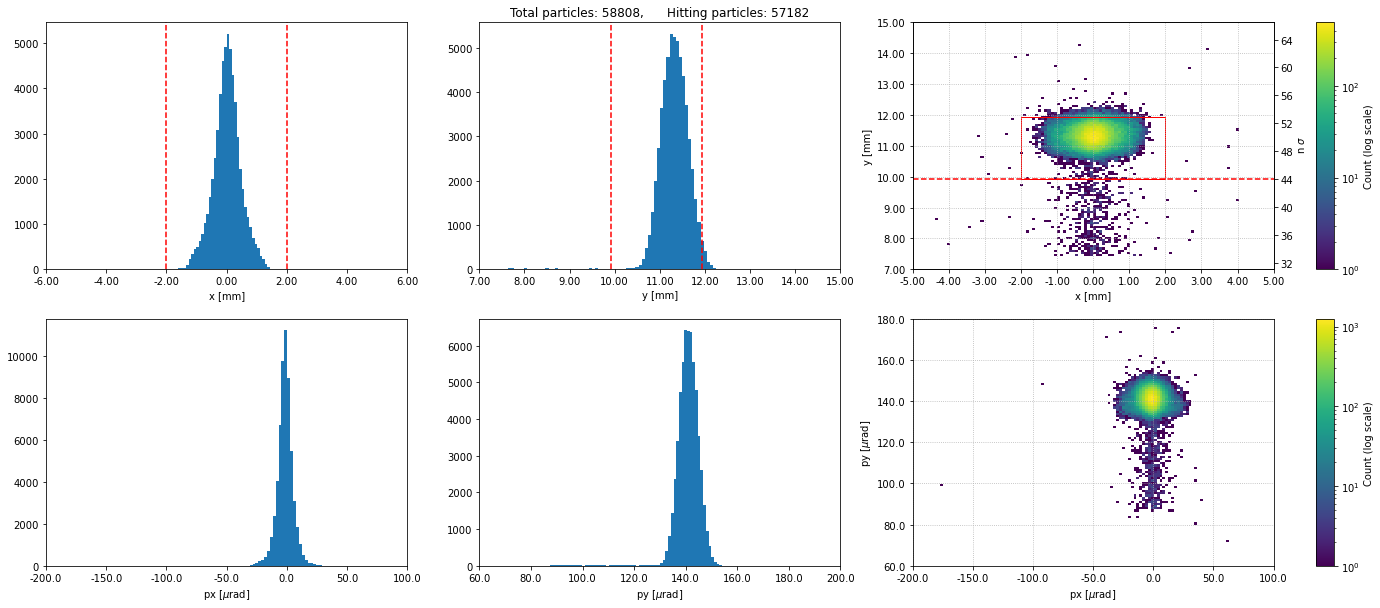

In [123]:
TARGET_IR3_IR7_7_2.compute_impact_particles()

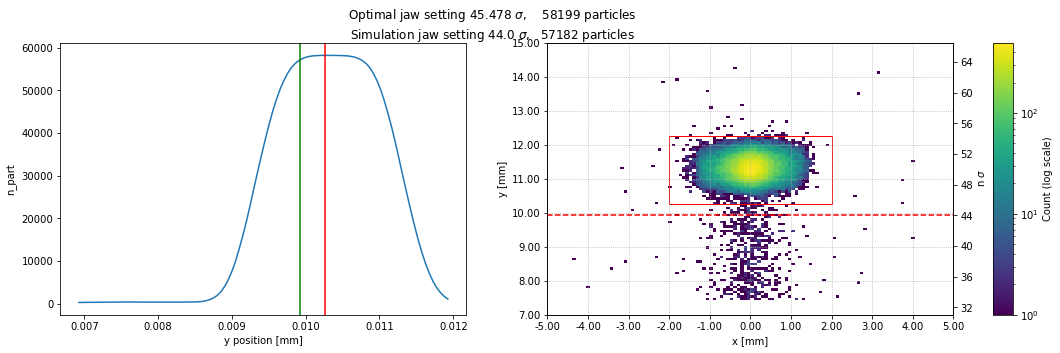

In [124]:
TARGET_IR3_IR7_7_2.optimize_POT(set=True)

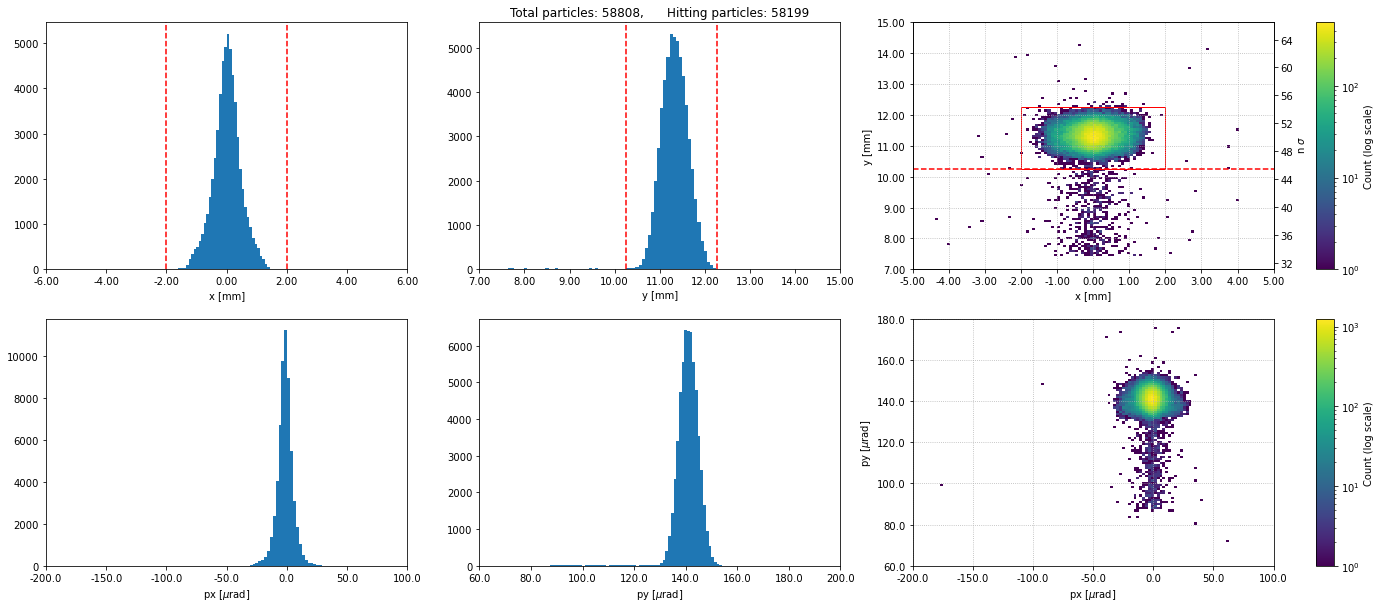

In [125]:
TARGET_IR3_IR7_7_2.compute_impact_particles(sigma=True)

In [165]:
TARGET_IR3_IR7_7_2.calculate_proton_on_target(10*60*60)

Protons on target: 3.079e+10 in  36000 s ==>  10.0 h
Flux: 8.552e+05 p/s


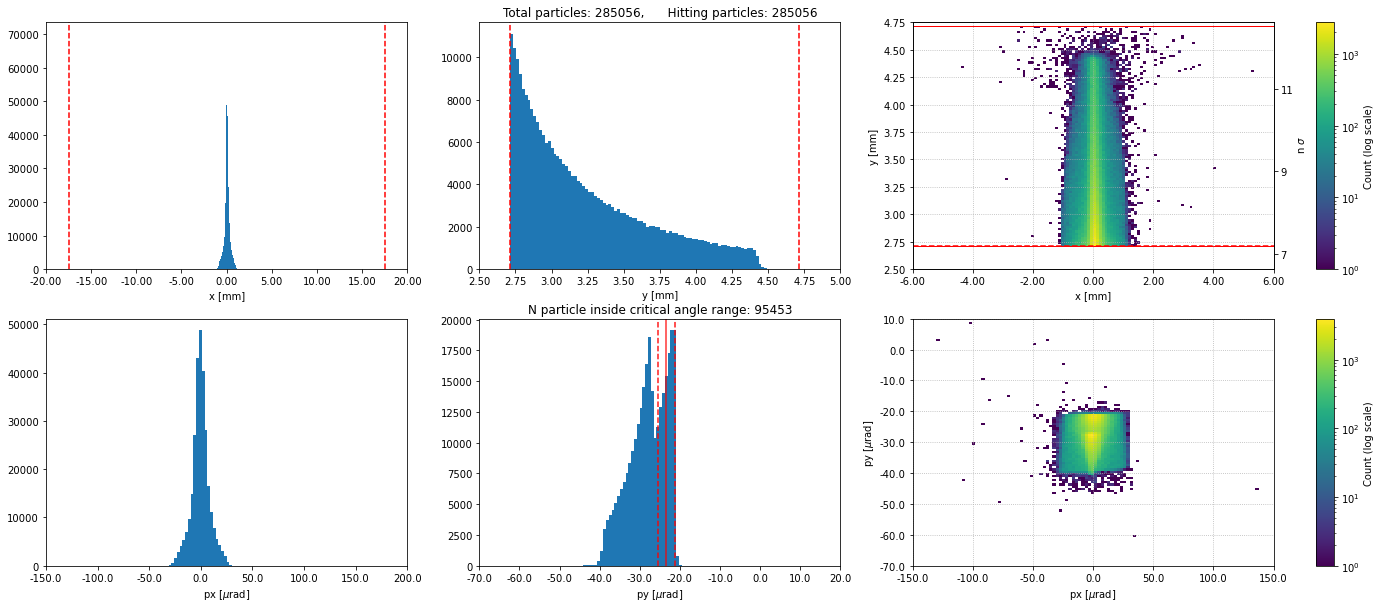

In [127]:
TCCS_IR3_IR7_7_2.compute_impact_particles(xpcrit=True)

In [128]:
TCCS_IR3_IR7_7_2.compute_channeled_part(TARGET_IR3_IR7_7_2.impact_part)

n particles that hit TCCP inside critical angle range: 	 58167
n part inside critical angle range: 			 95453 		60.94%
n part that hit TCCS (multiple):			 285056 	20.41%
n part that hit TCCP: 					 58199 		99.95%
total n particle in simulation: 			 1.0e+07	0.58%


Delta angle 1.8802222782643056e-07


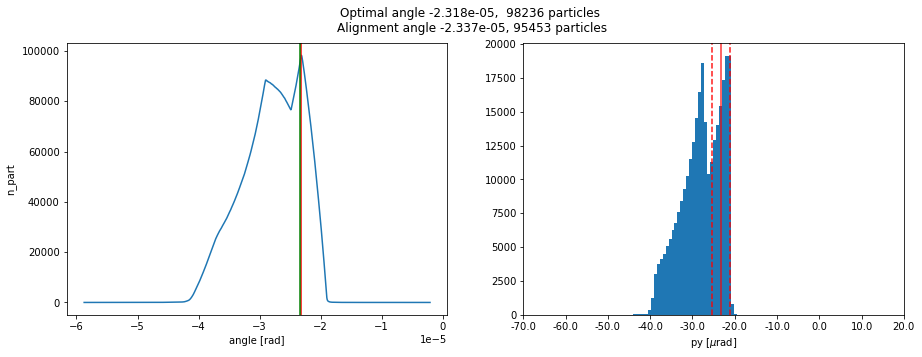

In [129]:
TCCS_IR3_IR7_7_2.optimize_alignment()

In [156]:
TARGET_IR3_IR7_7_2.load_lossmap(IR3_IR7rem_TCCS_7_2, zoom=False, plot=False)

In [131]:
TARGET_IR3_IR7_7_2.compute_losses()

,s,name,losses_type,losses,length,npart
5,6459.742798,tcp.d6r7.b2,Losses.COLL,11951335.0,0.600,7170801.0
1044,19885.183171,tccs.5r3.b2,Losses.COLL,539750.0,0.004,2159.0
1049,20005.545671,target.4l3.b2,Losses.COLL,11667200.0,0.005,58336.0
1053,20084.662376,tcla.a5l3.b2,Losses.COLL,1050.0,1.000,1050.0


In [132]:
#plt.hist(TARGET_IR3_IR7_7_2.data['at_turn'], bins=100)

# IR7 rematched

In [133]:
IR7rem_TCCS_7_2 = 'TEST_IR7_rem_TCCS_7.2__target_absorber_20240220-0926'

xp_crit0: 7.808420489040239e-11, Rcrit: 15745079155.883787

xp_crit0: 2.4692393673693e-06, Rcrit: 12.280701359157895
Delta angle -1.1887686184543034e-06


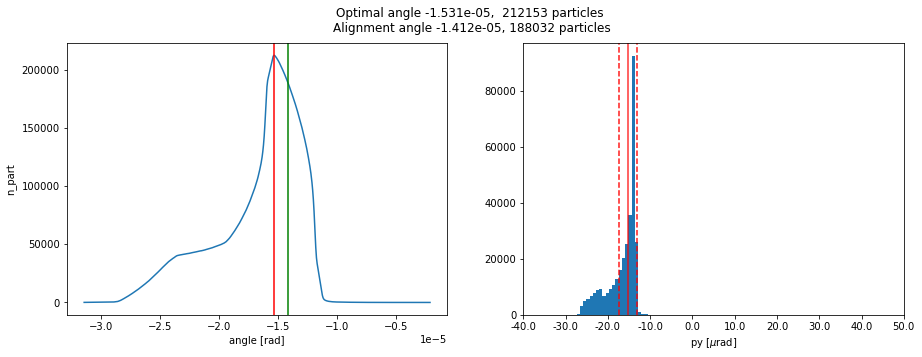

In [134]:
TCCS_IR7_7_2 = CrystalAnalysis(n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-1.4117809785569858e-05, sigma=0.0020239975348699253/7.2, line_idx=110029, pot_crit=21.34)
TCCS_IR7_7_2.load_particles(IR7rem_TCCS_7_2, df_key="TCCS_impacts")
TCCS_IR7_7_2.optimize_alignment()


In [135]:
TCCS_IR7_7_2.align_angle 

-1.4117809785569858e-05

In [166]:
#TARGET_IR7_7_2 = ParticleAnalysis_bkp(element_type='target', n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.010321720186418094, line_idx=110984)
TARGET_IR7_7_2 = TargetAnalysis(n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.004, sigma=0.010321720186418094/33.6, line_idx=110984)
TARGET_IR7_7_2.load_particles(IR7rem_TCCS_7_2, df_key="TARGET_impacts") 

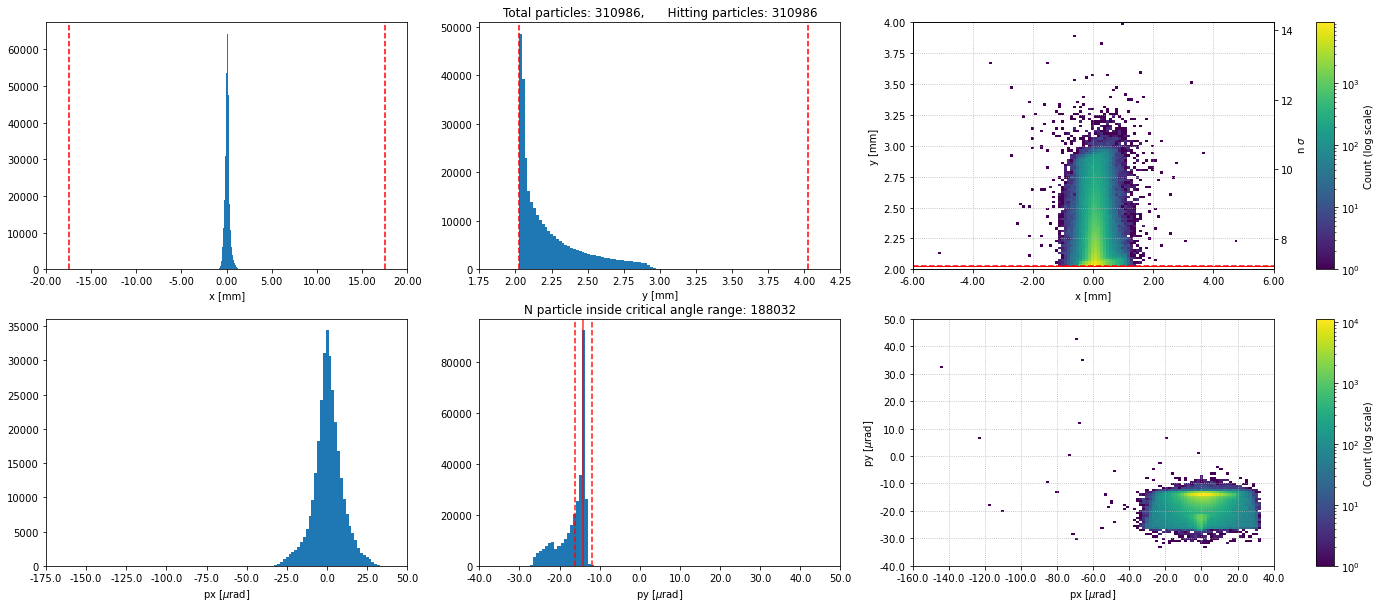

In [137]:
TCCS_IR7_7_2.compute_impact_particles(xpcrit=True)

In [138]:
TCCS_IR7_7_2.compute_channeled_part(TARGET_IR7_7_2.impact_part)

n particles that hit TCCP inside critical angle range: 	 138649
n part inside critical angle range: 			 188032 		73.74%
n part that hit TCCS (multiple):			 310986 	44.58%
n part that hit TCCP: 					 139105 		99.67%
total n particle in simulation: 			 1.0e+07	1.39%


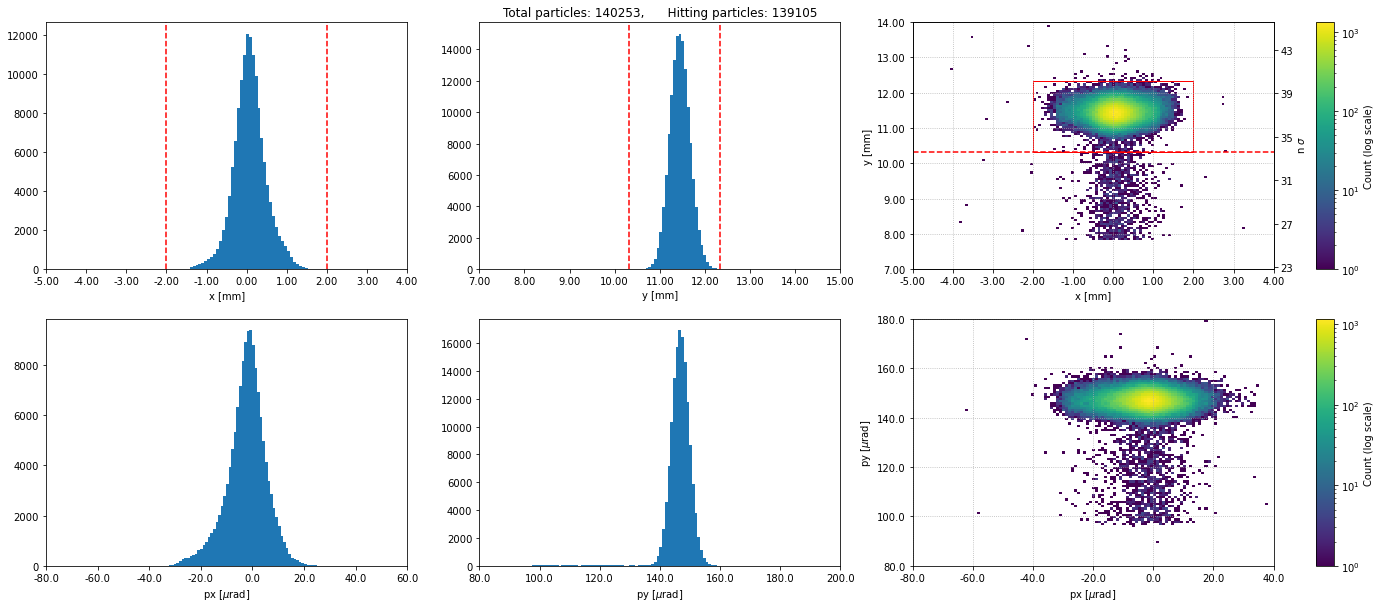

In [139]:
TARGET_IR7_7_2.compute_impact_particles(sigma=True)

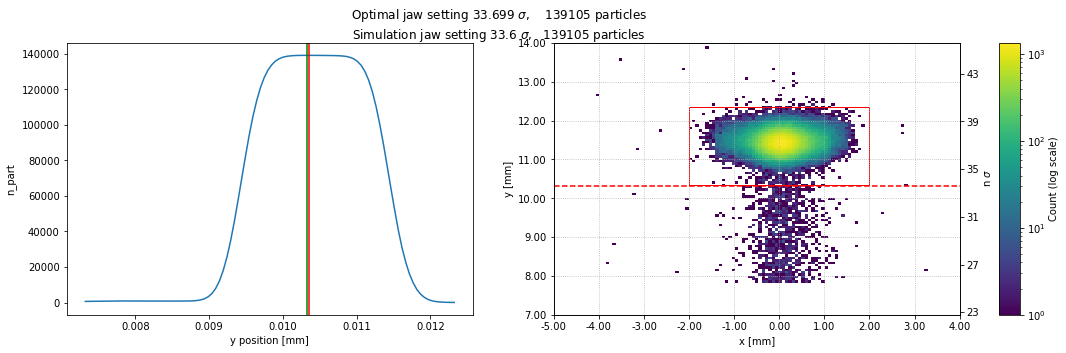

In [140]:
TARGET_IR7_7_2.optimize_POT(set=True)

In [141]:
TARGET_IR7_7_2.load_lossmap(IR7rem_TCCS_7_2, zoom=False, plot=False)

In [142]:
TARGET_IR7_7_2.compute_losses()

,s,name,losses_type,losses,length,npart
8,6459.742798,tcp.d6r7.b2,Losses.COLL,11229100.0,0.600,6737460.0
1024,19885.183171,tccs.5r3.b2,Losses.COLL,418250.0,0.004,1673.0
1028,20005.545671,target.4l3.b2,Losses.COLL,27837200.0,0.005,139186.0
1033,20084.662376,tcla.a5l3.b2,Losses.COLL,1584.0,1.000,1584.0


In [167]:
TARGET_IR7_7_2.calculate_proton_on_target(10*60*60)

Protons on target: 7.490e+10 in  36000 s ==>  10.0 h
Flux: 2.080e+06 p/s


# IR7 angle fixed

In [144]:
IR7rem_TCCS_7_2_angle = 'TEST_IR7rem_TCCS_7.2__target_absorber_20240223-1620'

xp_crit0: 2.4692393673693e-06, Rcrit: 12.280701359157895
Delta angle -6.007524368711116e-09


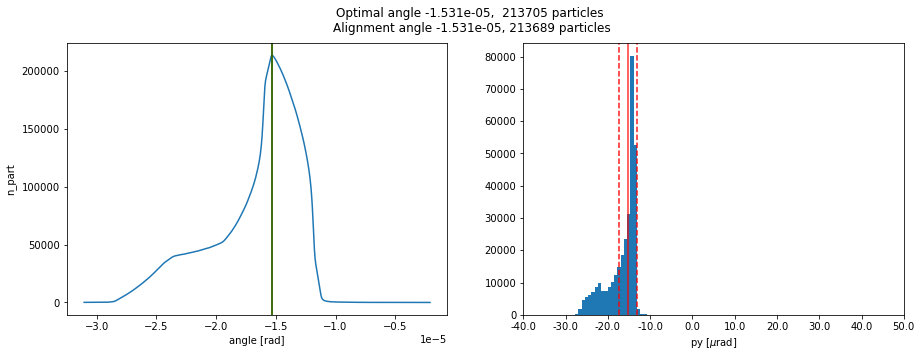

In [145]:
TCCS_IR7_7_2_angle  = CrystalAnalysis(n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-1.5306578399325507e-05, line_idx=110029, sigma=0.00028111076872336534)
TCCS_IR7_7_2_angle.load_particles(IR7rem_TCCS_7_2_angle, df_key="TCCS_impacts")
TCCS_IR7_7_2_angle.optimize_alignment()

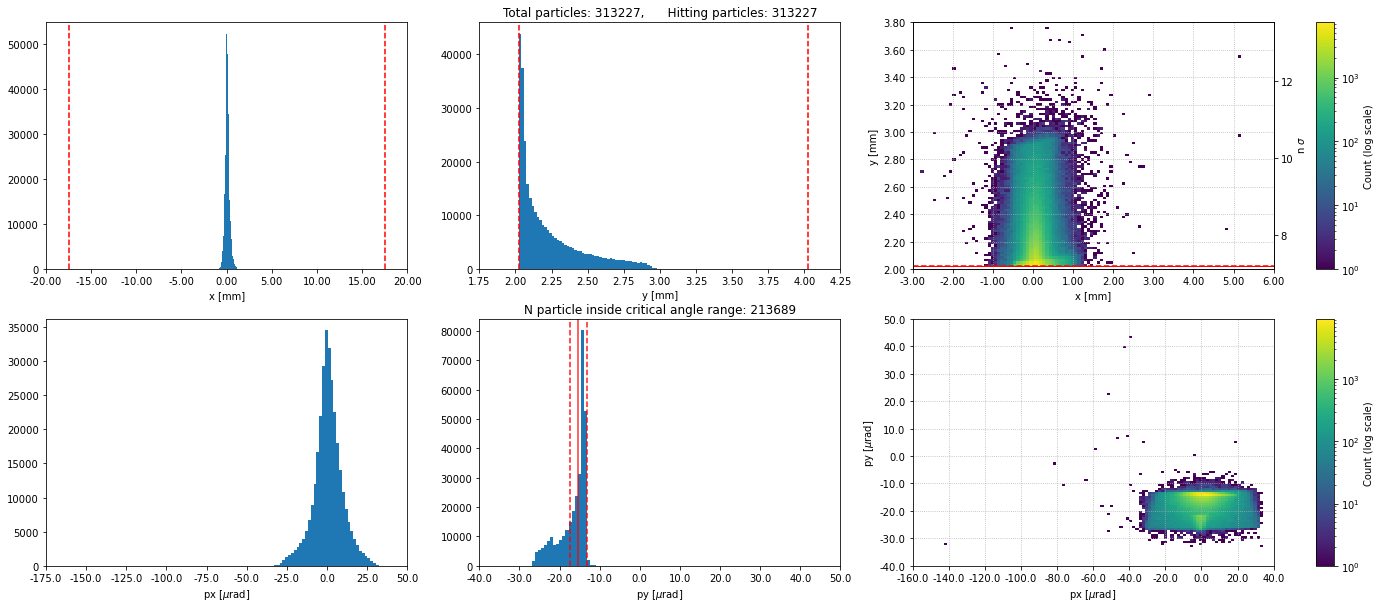

In [146]:
TCCS_IR7_7_2_angle.compute_impact_particles(xpcrit=True)

In [147]:
TARGET_IR7_7_2_angle = TargetAnalysis(n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.004, line_idx=110984, sigma=0.00030719405326038677)
TARGET_IR7_7_2_angle.load_particles(IR7rem_TCCS_7_2_angle, df_key="TARGET_impacts") 

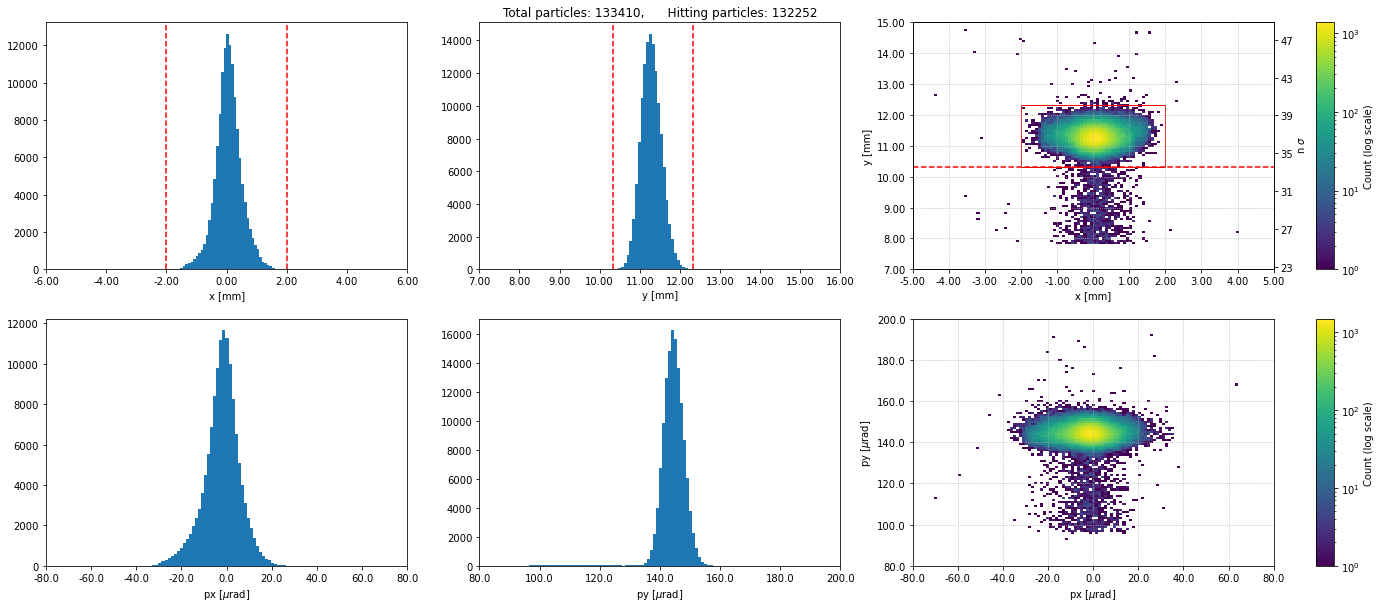

In [148]:
TARGET_IR7_7_2_angle.compute_impact_particles()

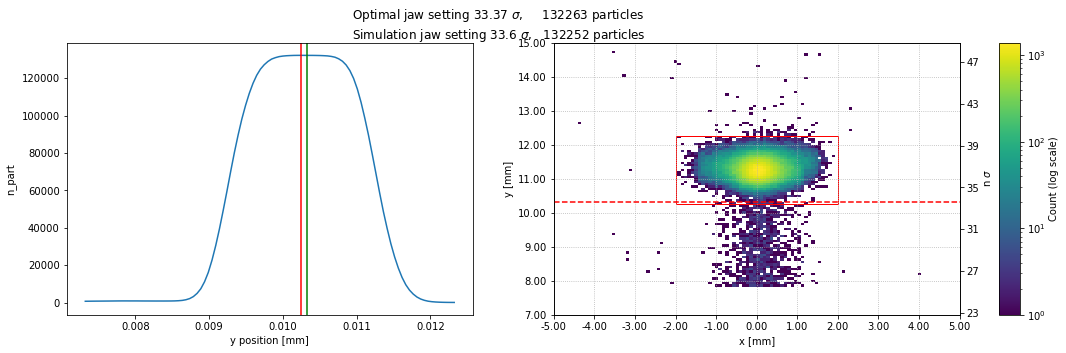

In [149]:
TARGET_IR7_7_2_angle.optimize_POT(set=True)

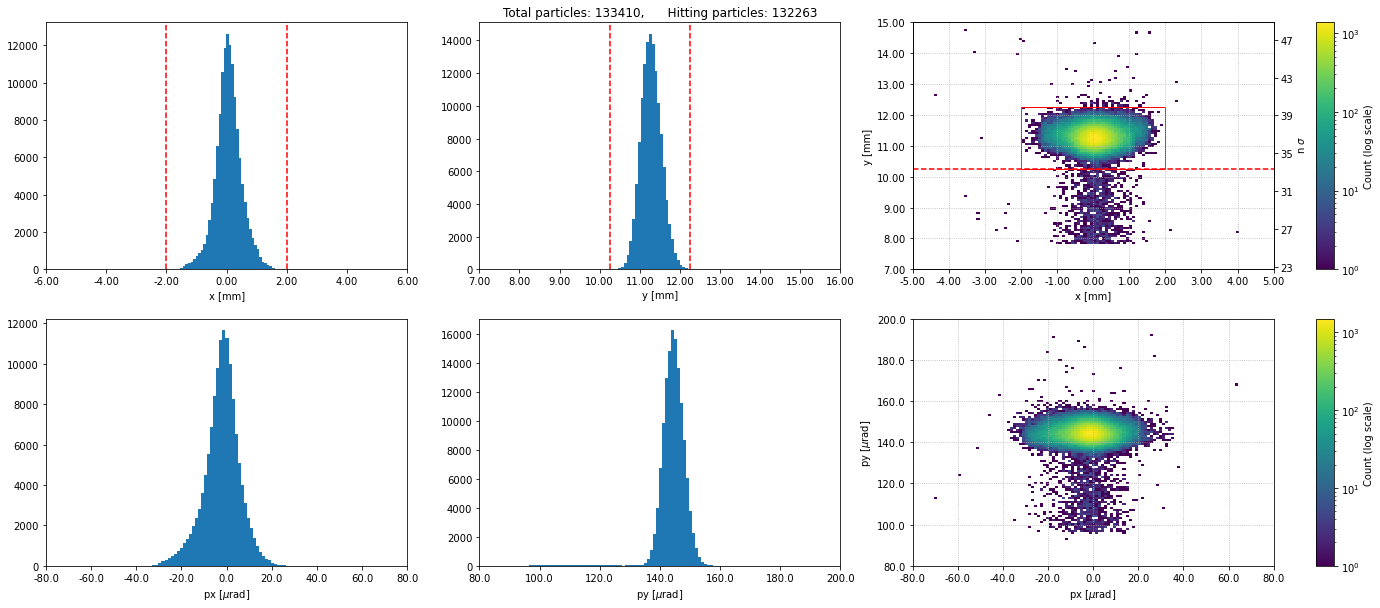

In [150]:
TARGET_IR7_7_2_angle.compute_impact_particles()

In [153]:
TARGET_IR7_7_2_angle.calculate_proton_on_target(10*60*60)

Protons on target: 7.121e+10 in  36000 s ==  10.0 h


In [151]:

TCCS_IR7_7_2.compute_channeled_part(TARGET_IR7_7_2.impact_part)


n particles that hit TCCP inside critical angle range: 	 138649
n part inside critical angle range: 			 188032 		73.74%
n part that hit TCCS (multiple):			 310986 	44.58%
n part that hit TCCP: 					 139105 		99.67%
total n particle in simulation: 			 1.0e+07	1.39%


In [152]:
TCCS_IR7_7_2_angle.compute_channeled_part(TARGET_IR7_7_2_angle.impact_part)

n particles that hit TCCP inside critical angle range: 	 131991
n part inside critical angle range: 			 213689 		61.77%
n part that hit TCCS (multiple):			 313227 	42.14%
n part that hit TCCP: 					 132263 		99.79%
total n particle in simulation: 			 1.0e+07	1.32%


In [80]:
print('Delta part in critical angle ', 213689 - 188032)

Delta part in critical angle  25657


In [155]:
print('Delta hits TCCP total',(131991 - 138649)) 
print('Delta hits TCCP total',(131991 - 138649)/131991*100) 

Delta hits TCCP total -6658
Delta hits TCCP total -5.044283322347736


In [78]:
print('Delta hits TCCS total', 313227 - 310986)

Delta hits TCCS total 2241


In [38]:
impacts = TARGET_IR7_7_2_angle.impact_part
channable_ids = TCCS_IR7_7_2_angle.data[(TCCS_IR7_7_2_angle.data['py'] > TCCS_IR7_7_2_angle.align_angle - np.abs(TCCS_IR7_7_2_angle.xp_crit)) & (TCCS_IR7_7_2_angle.data['py'] < TCCS_IR7_7_2_angle.align_angle  + np.abs(TCCS_IR7_7_2_angle.xp_crit))]['particle_id']
chann_num = len(np.intersect1d(channable_ids, impacts['particle_id']))
aa = len(np.intersect1d(TCCS_IR7_7_2_angle.data['particle_id'], impacts['particle_id']))
aa

131993

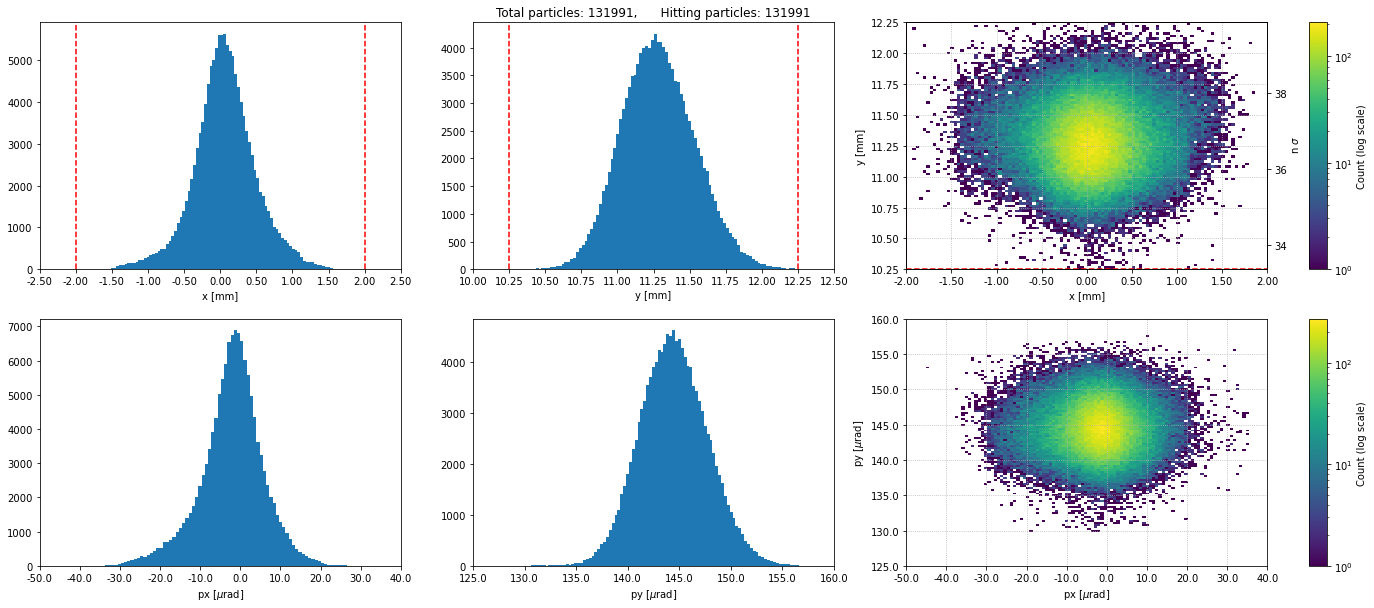

In [47]:
part = impacts[impacts['particle_id'].isin(np.intersect1d(channable_ids, impacts['particle_id']))]
TARGET_IR7_7_2_angle.plot_distributions(part['x'], part['y'], part['px'], part['py'])

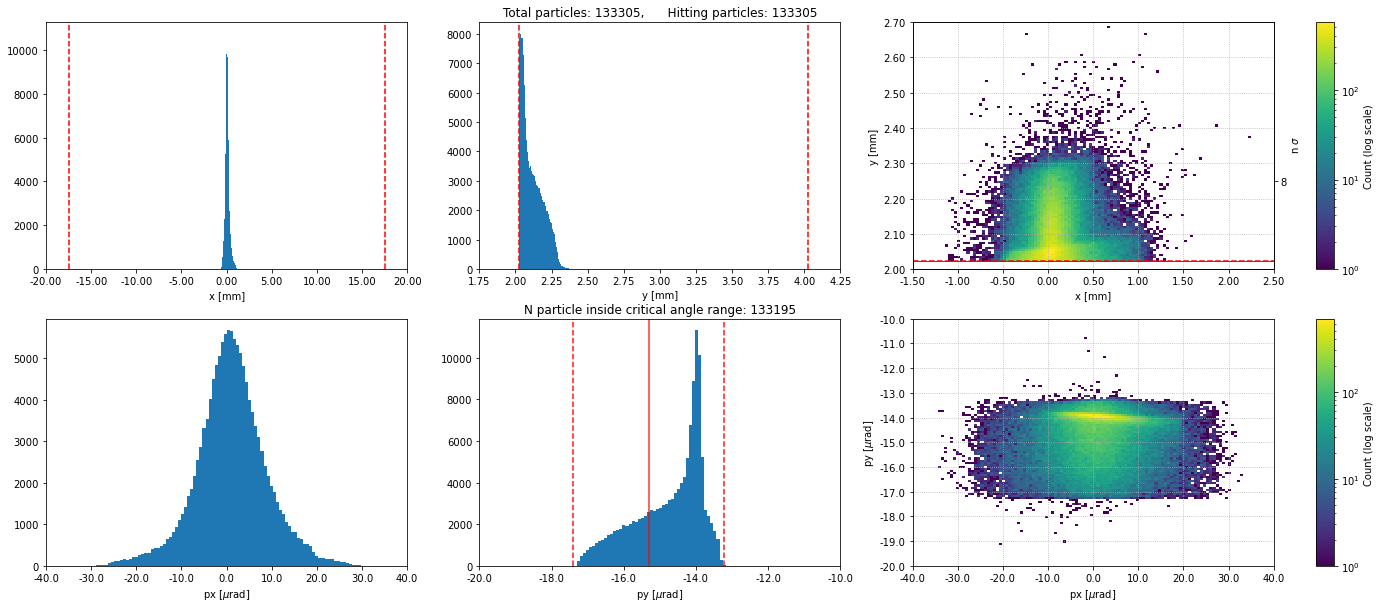

In [49]:
part2 = TCCS_IR7_7_2_angle.data[TCCS_IR7_7_2_angle.data['particle_id'].isin(np.intersect1d(channable_ids, impacts['particle_id']))]
TCCS_IR7_7_2_angle.plot_distributions(part2['x'], part2['y'], part2['px'], part2['py'], xpcrit=True)

In [52]:
impacts = TARGET_IR7_7_2.impact_part
channable_ids = TCCS_IR7_7_2.data[(TCCS_IR7_7_2.data['py'] > TCCS_IR7_7_2.align_angle - np.abs(TCCS_IR7_7_2.xp_crit)) & (TCCS_IR7_7_2.data['py'] < TCCS_IR7_7_2.align_angle  + np.abs(TCCS_IR7_7_2.xp_crit))]['particle_id']
chann_num = len(np.intersect1d(channable_ids, impacts['particle_id']))
aa = len(np.intersect1d(TCCS_IR7_7_2.data['particle_id'], impacts['particle_id']))
print(chann_num, aa, aa-chann_num)

138649 138654 5


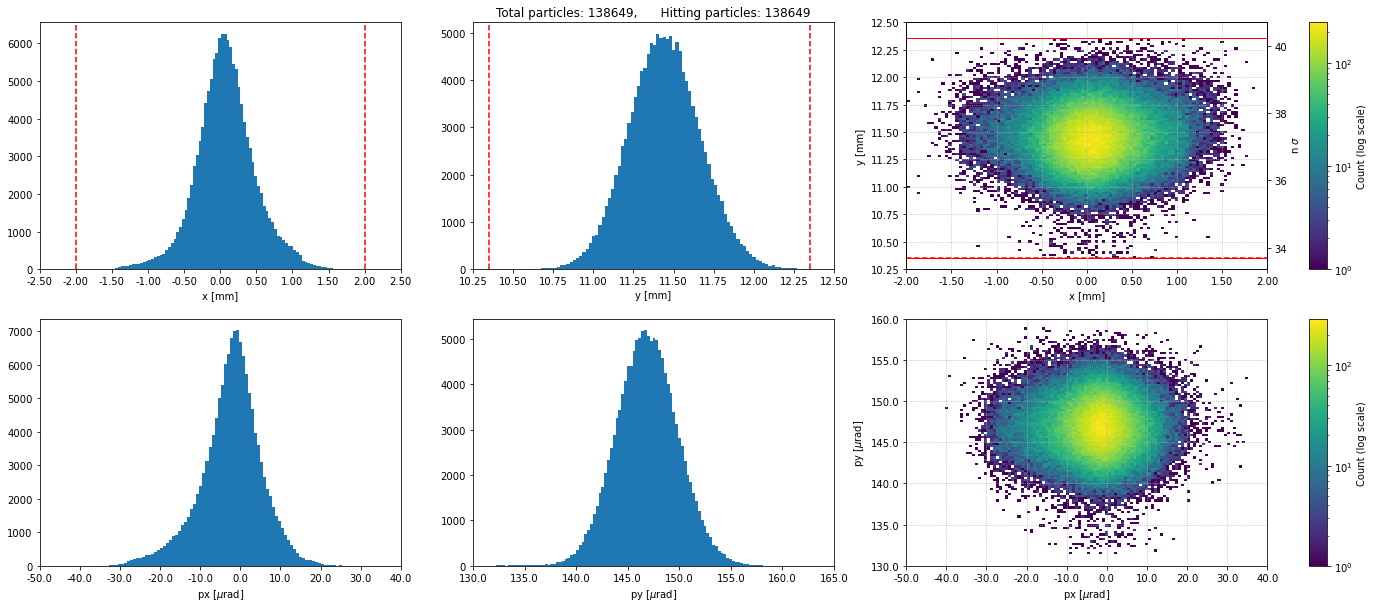

In [53]:
part = impacts[impacts['particle_id'].isin(np.intersect1d(channable_ids, impacts['particle_id']))]
TARGET_IR7_7_2.plot_distributions(part['x'], part['y'], part['px'], part['py'])

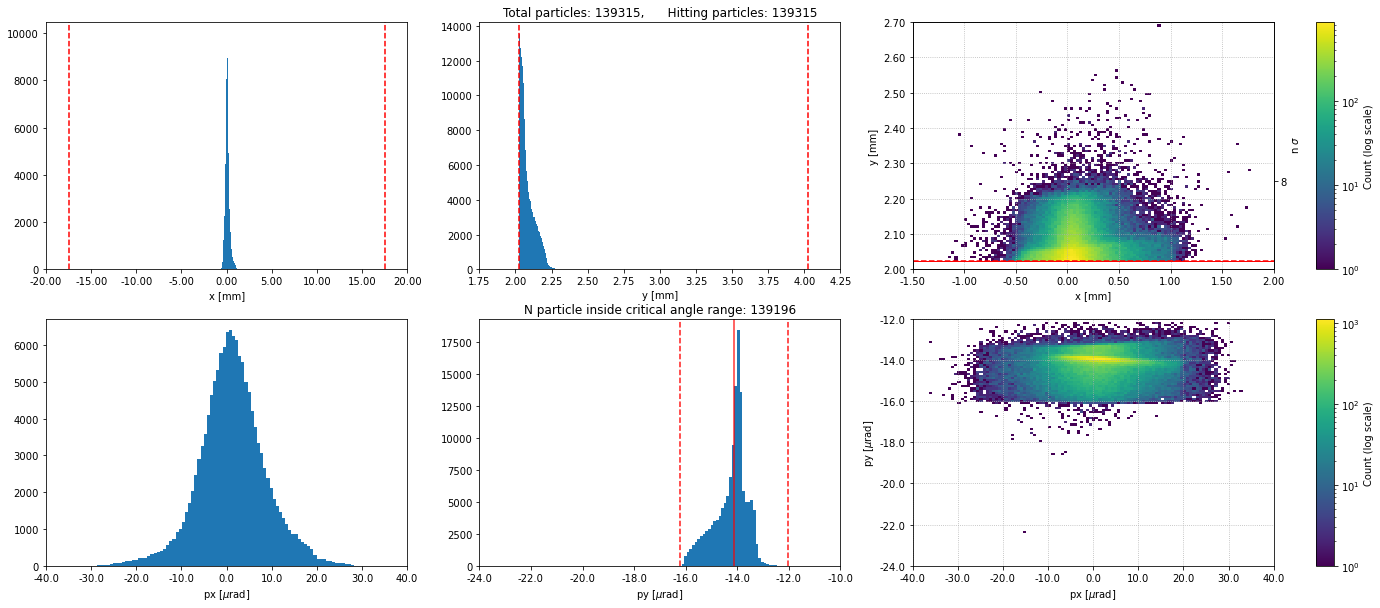

In [54]:
part2 = TCCS_IR7_7_2.data[TCCS_IR7_7_2.data['particle_id'].isin(np.intersect1d(channable_ids, impacts['particle_id']))]
TCCS_IR7_7_2.plot_distributions(part2['x'], part2['y'], part2['px'], part2['py'], xpcrit=True)

In [64]:
impacts = TARGET_IR7_7_2_angle.impact_part
channable_ids = TCCS_IR7_7_2_angle.data[(TCCS_IR7_7_2_angle.data['py'] > TCCS_IR7_7_2_angle.align_angle - np.abs(TCCS_IR7_7_2_angle.xp_crit)) & (TCCS_IR7_7_2_angle.data['py'] < TCCS_IR7_7_2_angle.align_angle  + np.abs(TCCS_IR7_7_2_angle.xp_crit))]['particle_id']
chann_num = len(np.intersect1d(channable_ids, impacts['particle_id']))
aa = len(np.intersect1d(TCCS_IR7_7_2_angle.data['particle_id'], impacts['particle_id']))

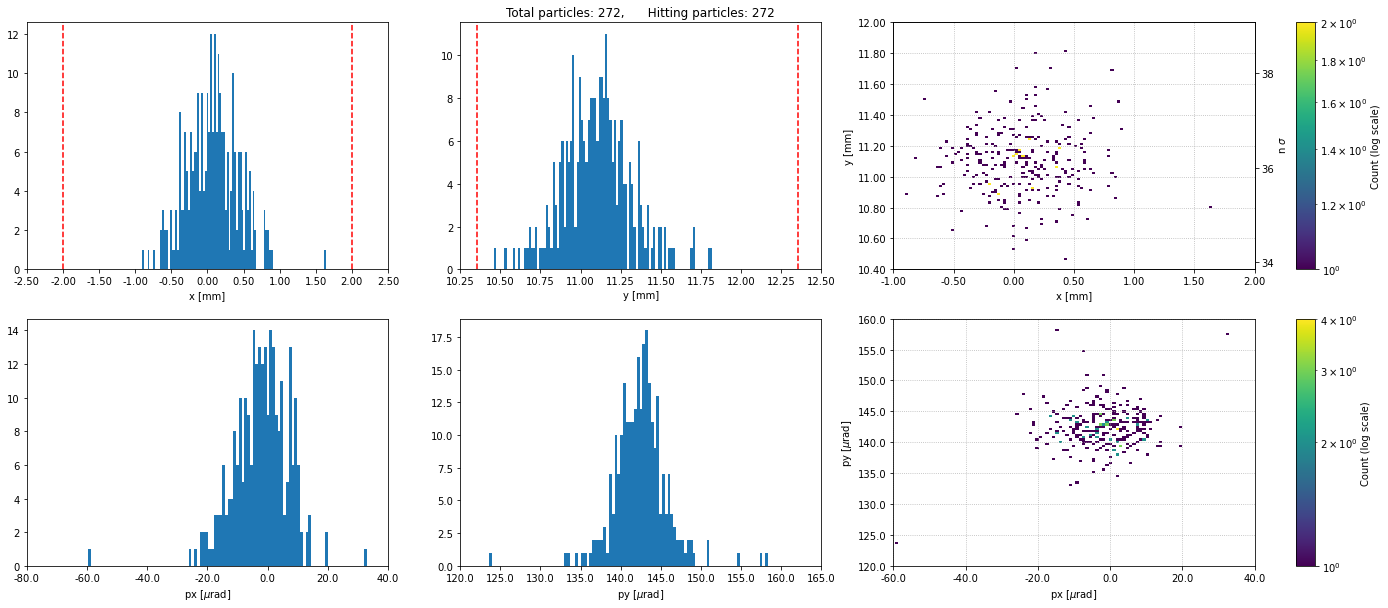

In [65]:
part = impacts[~impacts['particle_id'].isin(np.intersect1d(channable_ids, impacts['particle_id']))]
TARGET_IR7_7_2.plot_distributions(part['x'], part['y'], part['px'], part['py'])

Maximum inefficiency in the DS is 4.91e-06.
pymadx.Tfs.Load> normal file


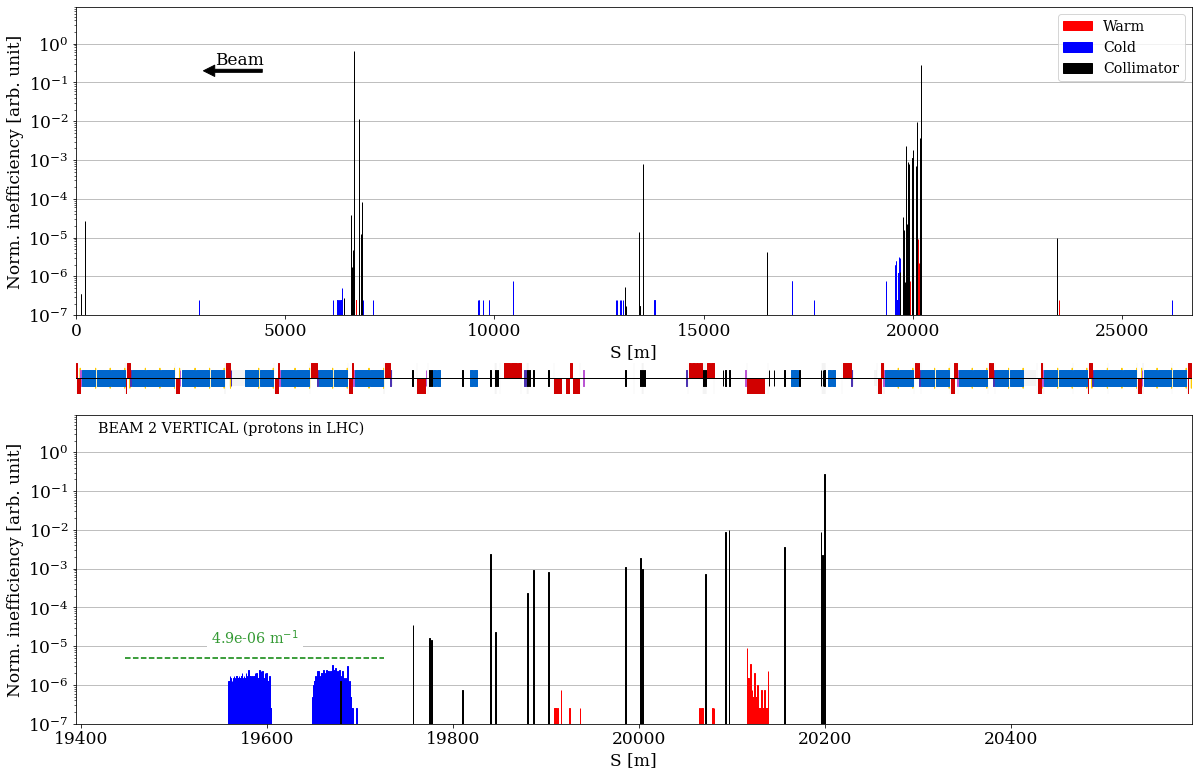

In [36]:
TCCS_IR7_7_2_angle.load_lossmap(IR7rem_TCCS_7_2_angle, zoom=True)

In [113]:
#TARGET_IR7_7_2_angle.save_particle_data(output_path='./Outputdata/')
#TARGET_IR7_7_2_new = TargetAnalysis(n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.004, line_idx=110984, sigma=0.00030719405326038677)
#TARGET_IR7_7_2_new.load_particles('./Outputdata/', default_path = "" , Condor = False, df_key="TARGET_impacts") 